# DQN trade

In this notebook a fully connected DQN model is trained on the crude oil daily dataset, enriched with the various tecnical indicators and the crude oil implied volatility index `OVX`.

The importance of **implied volatility** for market participants stems from the fact that it is one of the only data that is **forward-looking**. This is because market participants always trade contracts with an expiration date later in time. 

The goal of this notebook is to see how (if it is possible) a DQN trading agent can leverage this kind of data to learn a profitable trading strategy.

In [1]:
#@title **Imports** {display-mode: 'form'}

import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
import pandas as pd
import quantstats as qs

from sklearn.preprocessing import StandardScaler

from enum import Enum
import matplotlib.pyplot as plt

import torch as th
import torch.nn as nn
from torch.autograd import Variable

from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.dqn.policies import DQNPolicy

from gym_anytrading2.envs import FuturesEnv

# Training

Only 80% of the total data is used during the training phase. That’s because we want to avoid the model simply memorizing the dataset (overfitting) and obtaining a model that is generalized well in all market situations.

## Preprocessing

The preprocessing phase of the data consist in the following steps:

- adding cycling coding of date features
- scaled the data in the [-1, 1] range (this is done directily by the environment)

In [2]:
def add_cyclical_features(df):
    df['date'] = pd.to_datetime(df.index.copy(), format='%Y-%m-%d')
    df['day_sin'] = df['date'].apply(lambda x: np.sin(x.day * (2. * np.pi / 30)))
    df['day_cos'] = df['date'].apply(lambda x: np.cos(x.day * (2. * np.pi / 30)))
    df['month_sin'] = df['date'].apply(lambda x: np.sin(x.month * (2. * np.pi / 12)))
    df['month_cos'] = df['date'].apply(lambda x: np.cos(x.month * (2. * np.pi / 12)))
    df = df.drop('date', axis=1)
    return df

In [3]:
cl_df = pd.read_csv('data/CL_daily_adj.csv', parse_dates=True)
cl_df = cl_df.set_index('Date')
cl_df = add_cyclical_features(cl_df)
cl_df = cl_df.sort_index()

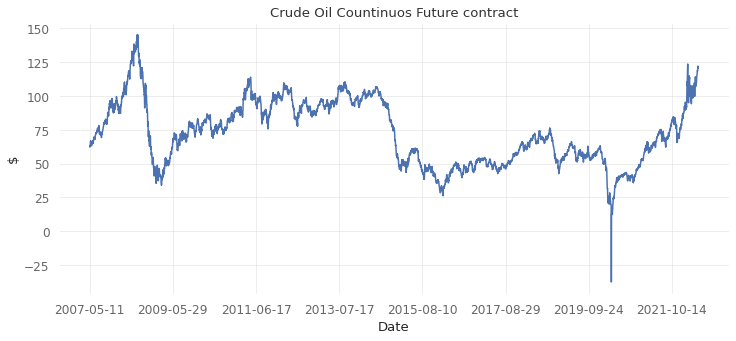

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
cl_df.close.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('$')
ax.set_title('Crude Oil Countinuos Future contract')
plt.show()

In [5]:
window_size = 21
training_portion = 0.8
episodes = 1000

train_cl_df = cl_df[0:int(np.floor(len(cl_df) * training_portion))]
test_cl_df = cl_df[int(np.floor(len(cl_df) * training_portion)):]

env = FuturesEnv(df=train_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(train_cl_df)))

# Model

## LSTM Feature extractor

Since we are dealing with timeseries data it could be useful to use a Neural Net architecture specialized to deal to sequentail data: a Reccurent Neural Network. 
As you might know vanilla Reccurent neural net suffers from exploding/vanishing gradient, so we are going to use a more sofisticated Reccurent architecture which have better memory properties: the LSTM. 

## DQN model

The DQN model is a fully connected neural network with 4 hidden layers with 256, 128, 128, and 64 neurons respectvely. 

The input of the neural netwotk is the daily data of the previous month (21 days).

In [8]:
policy_kwargs = {
    'net_arch':[256, 128, 128, 64]
    }
model = DQN("MlpPolicy", 
            env, 
            verbose=1,
            seed=0,
            train_freq=5,
            exploration_final_eps=0.1,
            exploration_fraction=0.65,
            policy_kwargs=policy_kwargs
            )
model.learn(total_timesteps=episodes*len(train_cl_df))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | -0.717   |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4841     |
|    time_elapsed     | 2        |
|    total_timesteps  | 11624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | -0.708   |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4846     |
|    time_elapsed     | 4        |
|    total_timesteps  | 23248    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.69e+03 |
|    ep_rew_mean      | -0.835

In [9]:
model.save('models/dqn_sb')

# Testing Results

Now that the model has been trained, let's test its performance on the testing data (out of sample data).

In [10]:
testing_env = FuturesEnv(df=test_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(test_cl_df)))

In [16]:
account_history = []
obs = testing_env.reset()
i = 0

while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = testing_env.step(action)

    print(f'step: {i}, reward: {rewards}, account_value: {testing_env.get_account_value()}, action: {action}, position: {info["position"]}')
    account_history.append(testing_env.get_account_value())

    if dones:
      break

    i += 1

step: 0, reward: 0, account_value: 1000000, action: 0, position: 0
step: 1, reward: 0, account_value: 1000000, action: 0, position: 0
step: 2, reward: 0, account_value: 1000000, action: 0, position: 0
step: 3, reward: 0, account_value: 1000000, action: 0, position: 0
step: 4, reward: 0, account_value: 1000000, action: 0, position: 0
step: 5, reward: 0, account_value: 1000000, action: 0, position: 0
step: 6, reward: 0, account_value: 1000000, action: 1, position: -1
step: 7, reward: -0.00973545170424908, account_value: 1000000, action: 1, position: -1
step: 8, reward: 0.006066031089624782, account_value: 1000000, action: 1, position: -1
step: 9, reward: 0.0035637956464232017, account_value: 1000000, action: 0, position: -1
step: 10, reward: 0.0003558085787403956, account_value: 1000000, action: 0, position: -1
step: 11, reward: -0.011495395840322479, account_value: 1000000, action: 1, position: -1
step: 12, reward: -0.032032142665514685, account_value: 1000000, action: 1, position: -1
s

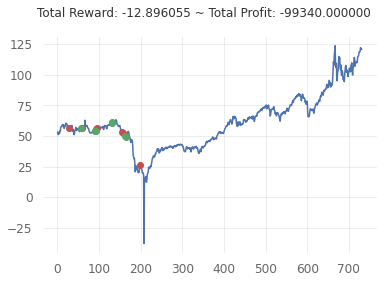

In [17]:
plt.cla()
testing_env.render_all()

## Testing period statistics

Let's see how the trading strategy learned in the training phase has performed on data that the model has never seen before. 

In [18]:
qs.extend_pandas()

net_worth = pd.Series(testing_env.history['total_profit'], index=test_cl_df.index[22:])
net_worth.index = pd.to_datetime(net_worth.index)

returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns, match_dates=True)

ValueError: Length of values (178) does not match length of index (710)